#### Perform a variety of pre-processing steps on images

* Image Loading
* Image Resizing (All images are 224 X 224 X 3 in jpg format)
* Image Cropping (All images in the dataset have been cropped so that only the image of a single card is present and the card occupies well over 50% of the pixels in the image)
* Convert to Grayscale 
* Image Enhancement (histogram equalization, sharpening, noise reduction, etc.)
* Normalization
* Data Augmentation: Apply data augmentation techniques to increase the size and diversity of your dataset. This can include random rotations, flips, translations, or other transformations to simulate different viewpoints or variations in lighting conditions.
* Image Filtering: : Apply filters or convolutions to smooth the image or enhance specific features. This can include techniques such as blurring (e.g., Gaussian blur), edge detection (e.g., Sobel, Canny), or other spatial filters.


In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split

from scipy.ndimage import convolve, binary_fill_holes
from scipy.stats import mode

from skimage import io, exposure
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import rotate, hough_line, hough_line_peaks, resize
from skimage.filters import threshold_otsu, sobel, gaussian, threshold_local

## Image Loading

In [2]:
# Load images from csv file

path = pd.read_csv('Dataset/cards.csv')
path_df = pd.DataFrame(path)
# For column names that contain space, replace the space with an underscore
path_df.columns = [c.replace(' ', '_') for c in path_df.columns]
path_df.head()

,class_index,filepaths,labels,card_type,data_set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [3]:
path_df['suit'] = path_df['labels'].str.split().str[-1]
print(path_df['suit'].unique())

['clubs' 'diamonds' 'hearts' 'spades' 'joker']


In [4]:
# Remove rows with jokers
path_df = path_df[~path_df['suit'].str.contains('joker', case=False)]
print("Unique suits without Jokers: ", path_df['suit'].unique())

Unique suits without Jokers:  ['clubs' 'diamonds' 'hearts' 'spades']


In [5]:
path_df.head()

,class_index,filepaths,labels,card_type,data_set,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,clubs


## Check Image Size

In [6]:
# All images are 224 X 224 X 3 in jpg format
# Double check by printing out unique shapes of images

image_shapes = []

for folder in path_df.data_set.unique():
    for filepath in path_df[path_df.data_set == folder].filepaths:
        image = cv2.imread('Dataset/' + filepath)

        if (filepath[-3:] == "jpg"):

            # Obtain shape of each image and store them in an array
            (width, height) = image.shape[1], image.shape[0]
            image_shapes.append((width, height))
    
# Return only unique shapes
unique_shapes = list(set(image_shapes))
print(unique_shapes)


[ WARN:0@1.164] global loadsave.cpp:244 findDecoder imread_('Dataset/train/ace of clubs/output'): can't open/read file: check file path/integrity


[(224, 224)]


## Convert Images to Grayscale

In [7]:
# Convert images to grayscale

def convert_to_grayscale(filepath):
    filename = 'Dataset/' + filepath
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray

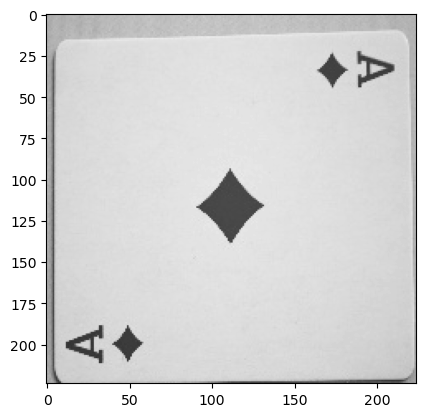

In [8]:
# Test if an image is actually gray

test_colored_image = 'train/ace of diamonds/001.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)
plt.imshow(test_gray_img, cmap='gray', vmin=0, vmax=255)

## Image Enhancement

Apply techniques to improve the image quality or highlight specific features. Includes contrast stretching, histogram equalization, and sharpening

In [9]:
# CONTRAST STRETCHING
def contrast_stretch(image):
    min_val = image.min()
    max_val = image.max()
    stretched = exposure.rescale_intensity(image, in_range=(min_val, max_val))
    return stretched

# HISTOGRAM EQUALIZATION
def clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(contrast_stretch(image)) 
    return equalized

# BLURRING AND SHARPENING
# Blurring the image
def blur_image(image):
    blur_img = gaussian(clahe(image), sigma = 3)
    return blur_img

# Sharpening image
def sharpen_image(image):
    blurred_image = blur_image(image)
    sharp_img = image + (image - blurred_image)
    return sharp_img

# NORMALIZATION
def normalize_img(image):
    normalized = (sharpen_image(image) - np.min(sharpen_image(image)))/(np.max(sharpen_image(image)) - np.min(sharpen_image(image)))   
    return normalized

### Data Augmentation
Apply data augmentation techniques to increase the size and diversity of dataset. This include rotations, flips, and augmentation. This simulate different viewpoints or variations.

In [10]:
#AUGMENTATION FUNCTIONS

#specified rotation
def image_rotation(image, angle_of_rotation):
    
    #rotate the image based on the rotation angle provided
    rotate_img = rotate(image, angle_of_rotation, resize = True)
    
    #resize the image if the size changed
    if rotate_img.shape != image.shape:
        rotated_img = resize(rotate_img, image.shape)
    else:
        rotated_img = rotate_img
     
    #return the final image
    return rotated_img


#random rotation function
def random_rotation(image):
    
    #randomly determine the rotation angle
    random_rotation = np.random.uniform(low = 0.0, high = 360.0)
    
    #rotate the image
    rotate_img = rotate(image, random_rotation, resize = True)
    
    #resize the image if the size changed
    if rotate_img.shape != image.shape:
        rotated_img = resize(rotate_img, image.shape)
    else:
        rotated_img = rotate_img
        
    #return the final image
    return rotated_img


#random flipping function
def random_flip(image):
    
    #generate a method to determine how the image should be flipped
    random_flip_axis = np.random.randint(low = 1, high = 4, dtype = int)
    
    #flip horizontal
    if random_flip_axis == 1:
        flipped_image = image[:, ::-1]
     
    #flip vertical
    elif random_flip_axis == 2:
        flipped_image = image[::-1, :]
    
    #No flip    
    elif random_flip_axis == 3:
        flipped_image = image
    
    #return the flipped image
    return flipped_image
 

#gamma correction - adjusts brightness of image
def gamma_correction(image):
    random_gamma = np.random.uniform(low = 0, high = 1)
    
    gamma_adjusted_image = exposure.adjust_gamma(image, 2)
    return gamma_adjusted_image


#logarithmic correction - replaces pixels with their log value
def log_correction(image):
    log_adjusted_image =  exposure.adjust_log(image)
    return log_adjusted_image


#data augmentation function
def data_augmentation(image):
    random_correction = np.random.randint(low = 1, high = 4, dtype = int)
    
    rotated_image = random_rotation(image)
    flipped_image = random_flip(rotated_image)
    
    #random correction of the image
    if random_correction == 1:
        augmentated_image = gamma_correction(flipped_image)
        
    elif random_correction == 2:
        augmentated_image = log_correction(flipped_image)
    
    elif random_correction == 3:
        augmentated_image = flipped_image
    
    return augmentated_image

### Test all functions and display images

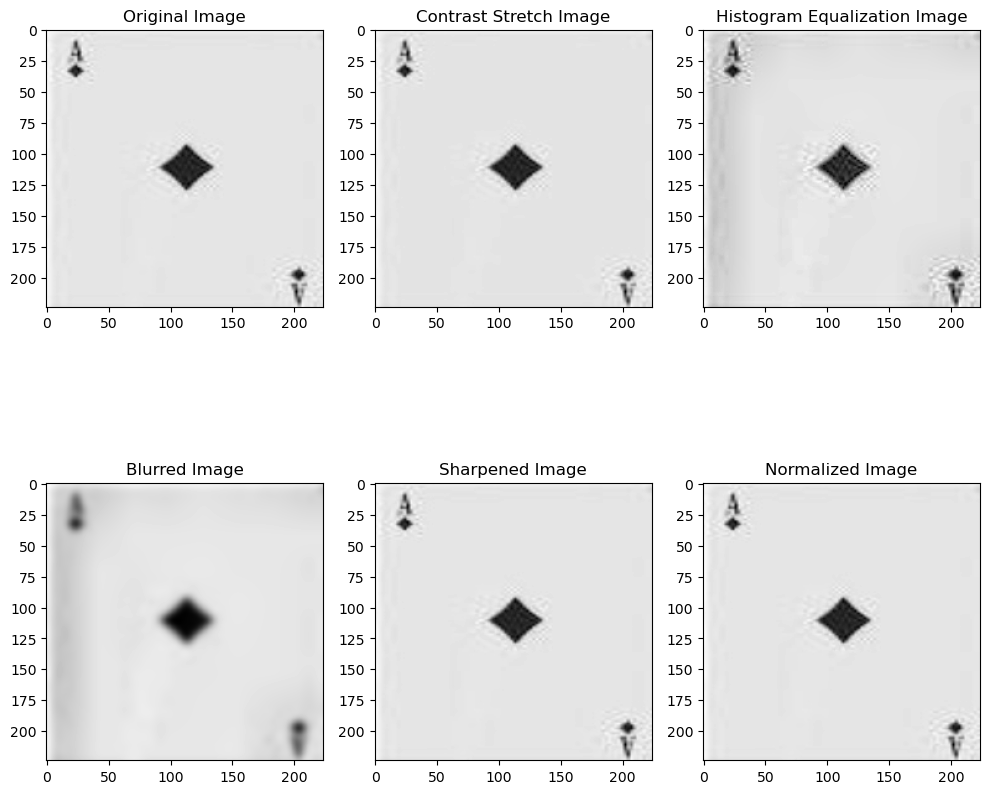

In [11]:
# Test functions and display images

test_colored_image = 'train/ace of diamonds/112.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)
gray_img = test_gray_img

fig, axes = plt.subplots(2,3, figsize = (10,10))

axes[0,0].imshow(gray_img, cmap = 'gray')
axes[0,0].set_title('Original Image')

axes[0,1].imshow(contrast_stretch(gray_img), cmap = 'gray')
axes[0,1].set_title('Contrast Stretch Image')

axes[0,2].imshow(clahe(gray_img), cmap = 'gray')
axes[0,2].set_title('Histogram Equalization Image')

axes[1,0].imshow(blur_image(gray_img), cmap = 'gray')
axes[1,0].set_title('Blurred Image')

axes[1,1].imshow(sharpen_image(gray_img), cmap = 'gray')
axes[1,1].set_title('Sharpened Image')

axes[1,2].imshow(normalize_img(gray_img), cmap = 'gray')
axes[1,2].set_title('Normalized Image')

plt.tight_layout()
plt.show()


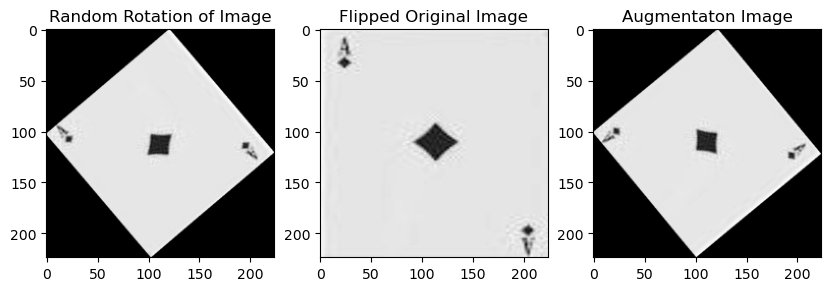

In [12]:
#Displaying of Augmented Images
rotated_img = random_rotation(normalize_img(gray_img)) #random rotation

flipped_original_image = random_flip(normalize_img(gray_img)) #flipping the original image

augmentated_image = data_augmentation(normalize_img(gray_img)) #data augmentation funtion

#plotting the flipped and rotated images
fig, axes = plt.subplots(1,3, figsize = (10,10))

axes[0].imshow(rotated_img, cmap = 'gray')
axes[0].set_title('Random Rotation of Image')

axes[1].imshow(flipped_original_image, cmap = 'gray')
axes[1].set_title('Flipped Original Image')

axes[2].imshow(augmentated_image, cmap = 'gray')
axes[2].set_title('Augmentaton Image')

plt.show()

### Concolidate enhanced images and augmented images

In [13]:
all_images = []
all_labels = []

for index, row in path_df.iterrows():
    filepath = row['filepaths']
    label = row['suit']
    try:
        image = convert_to_grayscale(filepath)
        if image is not None:
            # Perform any necessary preprocessing on the image
            all_images.append(normalize_img(image))
            all_labels.append(label)
        else:
            continue
    except Exception as e:
            continue


# append augmented images


[ WARN:0@7.333] global loadsave.cpp:244 findDecoder imread_('Dataset/train/ace of clubs/output'): can't open/read file: check file path/integrity


[array([[0.99912246, 0.99912246, 0.99912246, ..., 0.99912246, 0.99912246,
        0.99912246],
       [0.99912246, 0.99912246, 0.99912246, ..., 0.99912246, 0.99912246,
        0.99912246],
       [0.99912246, 0.99912246, 0.99912246, ..., 0.99912246, 0.99912246,
        0.99912246],
       ...,
       [0.99591476, 0.99193636, 0.98397707, ..., 0.99912246, 0.99912246,
        0.99912246],
       [0.99967342, 0.99967915, 0.98375091, ..., 0.99912246, 0.99912246,
        0.99912246],
       [0.99948443, 0.99152116, 0.99949739, ..., 0.99912246, 0.99912246,
        0.99912246]]), array([[0.97147517, 0.98323042, 0.97539347, ..., 0.96753416, 0.96753682,
        0.96362115],
       [0.97147478, 0.97931183, 0.97539355, ..., 0.96753447, 0.96753695,
        0.9636211 ],
       [0.97539301, 0.9753934 , 0.97539381, ..., 0.96753476, 0.967537  ,
        0.96362089],
       ...,
       [0.9675336 , 0.96753585, 0.96753832, ..., 0.96755936, 0.96363987,
        0.96363922],
       [0.97145071, 0.96753486, 0

### Train-Train-Validation Split

In [ ]:
# Splitting into train, test, and validation sets (80% - 10% - 10% split)
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

### Image Filtering

Apply filters or convolutions to smooth the image or enhance specific features. This can include techniques such as blurring (e.g., Gaussian blur), edge detection (e.g., Sobel, Canny), or other spatial filters.

In [ ]:
#THRESHOLDING, BINARIZATON AND FILLING OF IMAGES

test_colored_image = 'train/ace of diamonds/001.jpg'
test_gray_img = convert_to_grayscale(test_colored_image)
gray_img = test_gray_img

img = sharpen_image(gray_img)

#thresholding Image
def thresholding_image(image):
    
    threshold_image = threshold_otsu(image)
    return threshold_image

#binarizing image
def binarizing_image(image):
    
    binary_image = image > thresholding_image(image)
    return binary_image

#filling image, best results are based on a binarized image
def fill_image(image):
    
    filled_image = binary_fill_holes(image)
    return filled_image
    

figs, axes = plt.subplots(1,3, figsize = (10,10))

axes[0].imshow(img, cmap = 'gray')
axes[0].set_title('Sharpened Image')

axes[1].imshow(binarizing_image(img), cmap = 'gray')
axes[1].set_title('Binarized Image')

axes[2].imshow(fill_image(binarizing_image(img)), cmap = 'gray')
axes[2].set_title('Filled Image')

plt.show()

In [ ]:
#EDGE DETECTION USING CANNY AND SOBEL METHODS

binary_img = binarizing_image(img)
filled_bin = fill_image(binarizing_image(img))

#sobel method
sobel_edge_img = sobel(gray_img)
sobel_binary_edge_img = sobel(binary_img) #thresholding with no filling
sobel_filled_edge_img = sobel(filled_bin) #filled image with thresholding

#canny method
canny_edge_img = canny(gray_img, sigma = 3)
canny_binary_edge_img = canny(binary_img, sigma = 3) #thresholding with no filling
canny_filled_edge_img = canny(filled_bin, sigma = 3) #filled image with thresholding

#plot images
figs, axes = plt.subplots(2,3, figsize = (10,10))

axes[0,0].imshow(sobel_edge_img, cmap = 'gray')
axes[0,0].set_title('sobel_edge_img')

axes[0,1].imshow(sobel_binary_edge_img, cmap = 'gray')
axes[0,1].set_title('sobel_binary_edge_img')

axes[0,2].imshow(sobel_filled_edge_img, cmap = 'gray')
axes[0,2].set_title('sobel_filled_edge_img')

axes[1,0].imshow(canny_edge_img, cmap = 'gray')
axes[1,0].set_title('canny_edge_img')

axes[1,1].imshow(canny_binary_edge_img, cmap = 'gray')
axes[1,1].set_title('canny_binary_edge_img')

axes[1,2].imshow(canny_filled_edge_img, cmap = 'gray')
axes[1,2].set_title('canny_filled_edge_img')

plt.show()

In [ ]:
#CALCULATING ANGLES OF ROTATION
#Imperfect. None of the methods used produced a reliable angle of rotation

import warnings
warnings.filterwarnings('ignore')

def hough_line_detection(h_img, title):
    '''
    We can determing the angle of rotation based on the angle between the identified hough lines (theta) detected
    '''
    h, theta, d = hough_line(h_img)
    besth, besttheta, bestd = hough_line_peaks(h, theta, d)
    
    if len(besttheta) > 0:
        r_angle = np.rad2deg(mode(besttheta)[0][0])
        
    else:
        r_angle = 0
#     print(f'{title}, rotation angle: {r_angle}')
    return r_angle

#rotation angle based on the different edge detection methods used

se_img = hough_line_detection(sobel_edge_img, 'sobel edge')
sbe_img = hough_line_detection(sobel_binary_edge_img, 'sobel edge with threshold and no fill')
sfe_img = hough_line_detection(sobel_filled_edge_img, 'sobel edge with threshold and fill')

ce_img = hough_line_detection(canny_edge_img, 'canny edge ')
cbe_img = hough_line_detection(canny_binary_edge_img, 'canny edge with threshold and no fill')
cfe_img = hough_line_detection(canny_filled_edge_img, 'canny edge with threshold and fill')